In [1]:
from coordinate import dataset_list, coordinate
from preprocess import preprocess, preprocess_adlmr
from feature import extract_feature
import numpy as np
import pickle as pkl
from collections import Counter
import time
from fcmeans import FCM
from densityratio import Densratio

In [ ]:
"""
    Loading Data
    twor.2009: no interleaving
    twor.summer.2009: interleaving
    twor.2010: interleaving
"""

event_dict={}
trans_dict={}
activ_dict={}
for ds_name in dataset_list:
    if ds_name!='adlmr':
        continue
    print(ds_name)
    f=open('./dataset/{}/annotated'.format(ds_name), 'rb')
    raw=f.readlines()
    f.close()
    if ds_name==dataset_list[-1]:
        events, trans_indices, activity_set=preprocess_adlmr(raw)
    else:
        events, trans_indices, activity_set=preprocess(raw) # event format: <sensor, value, timestamp>
    event_dict[ds_name]=events
    trans_dict[ds_name]=trans_indices
    activ_dict[ds_name]=activity_set

with open('./save/event_dict','wb') as f:
    pkl.dump(event_dict, f)
with open('./save/trans_dict','wb') as f:
    pkl.dump(trans_dict, f)

In [2]:
with open('./save/event_dict','rb') as f:
    event_dict=pkl.load(f)
with open('./save/trans_dict','rb') as f:
    trans_dict=pkl.load(f)
    

In [3]:
sensor_set=set()
for item in event_dict.keys():
    sensor_set=sensor_set | set(np.array(event_dict[item])[:,0])

In [4]:
# clustering in online
with open('./save/online_group_A','rb') as f:
    online_group_A=pkl.load(f)
with open('./save/online_group_B','rb') as f:
    online_group_B=pkl.load(f)
with open('./save/online_A_score','rb') as f:
    online_A_score=pkl.load(f)
with open('./save/online_B_score','rb') as f:
    online_B_score=pkl.load(f)
with open('./save/online_centers','rb') as f:
    online_centers=pkl.load(f)
print(len(online_group_A), len(online_A_score))
print(len(online_group_B), len(online_B_score))
print(len(online_centers))

2580 2580
2418 2418
4998


In [9]:
target_subsequence=online_group_B
len(target_subsequence)

ws, vs=30, 2
threshold=0.3
scores=[]
start=time.time()

wbt=[];wt=[];wat=[]
fb=[];ff=[];fa=[]

for i, event in enumerate(target_subsequence):
    if i%1000==0:
        print("{}/{}, elapsed time: {}".format(i, len(target_subsequence)-1, time.time()-start))
    w_b_t=target_subsequence[-ws+i-1:i-1]
    w_t=target_subsequence[-ws+i:i]
    w_a_t=target_subsequence[-ws+i+1:i+1]
    if i==len(target_subsequence)-1:
        w_a_t=w_a_t+[target_subsequence[-1]]

    if -ws+i-1<0:
        fe=target_subsequence[0]    # first event
        w_b_t=[fe for i in range(ws-len(w_b_t))]+w_b_t
        w_t=[fe for i in range(ws-len(w_t))]+w_t
        w_a_t=[fe for i in range(ws-len(w_a_t))]+w_a_t
    
    wbt.append(w_b_t); wt.append(w_t); wat.append(w_a_t)

    f_b=extract_feature(w_b_t, sensor_set, coordinate)
    f_=extract_feature(w_t, sensor_set, coordinate)
    f_a=extract_feature(w_a_t, sensor_set, coordinate)

    fb.append(f_b); ff.append(f_); fa.append(f_a)

    v_b, v_a= np.array([f_b, f_]), np.array([f_, f_a])
    score=Densratio(x=v_b, y=v_a).SEPDiv
    scores.append(score)

dic={
    'wbt':wbt,
    'wt':wt,
    'wat':wat,
    'fb':fb,
    'f':ff,
    'fa':fa
}
with open('./save/online_B_dict','wb') as f:
    pkl.dump(dic, f)
with open('./save/online_B_score','wb') as f:
    pkl.dump(scores, f)

0/2417, elapsed time: 0.0006058216094970703
1000/2417, elapsed time: 1236.7229497432709
2000/2417, elapsed time: 2467.9910809993744


In [8]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

threshold=0.3
subsequenceA, subscoreA=online_group_A, online_A_score
xA=np.array(subscoreA)
xA_=np.where(xA<threshold, 0, xA)
peaks_A, _ = find_peaks(xA_, distance=5)

bucket_A=[]
for i in range(len(peaks_A)):
    if i==0:
        segment=subsequenceA[:peaks_A[i]]
        bucket_A.append(segment)
        # print(np.array(segment))
        # c=[coordinate[item[0]] for item in segment]
        # c_x=[coordinate[item[0]][0] for item in segment]
        # c_y=[coordinate[item[0]][1] for item in segment]
        # r=[int(item[3]) for item in segment]
        # fig, ax=plt.subplots()

        # sc=ax.scatter(c_x, c_y, c=r, alpha=0.7, s=1e2)
        # for j in range(len(segment)):
        #     plt.annotate(segment[j][0], c[j], label=r[j])
        # ax.legend(*sc.legend_elements(num=1), title='resident')
        # plt.show()
        
    elif i==len(peaks_A)-1:
        bucket_A.append(subsequenceA[peaks_A[i]:])
    else:
        bucket_A.append(subsequenceA[peaks_A[i]:peaks_A[i+1]])

In [9]:
subsequenceB, subscoreB=online_group_B, online_B_score
xB=np.array(subscoreB)
xB_=np.where(xB<threshold, 0, xB)
peaks_B, _ = find_peaks(xB_, distance=5)

bucket_B=[]
for i in range(len(peaks_B)):
    if i==0:
        segment=subsequenceB[:peaks_B[i]]
        bucket_B.append(segment)

    elif i==len(peaks_B)-1:
        bucket_B.append(subsequenceB[peaks_B[i]:])
    else:
        bucket_B.append(subsequenceB[peaks_B[i]:peaks_B[i+1]])

In [60]:
# cluster

dominant_cnt=0
d_threshold=0.9
for i, item in enumerate(bucket_A):

    user_cnt=Counter(np.array(item)[:,3])
    ratio_1=(user_cnt['1']+user_cnt['12']+user_cnt['21']+user_cnt['11'])/sum(user_cnt.values())
    ratio_2=(user_cnt['2']+user_cnt['12']+user_cnt['21']+user_cnt['22'])/sum(user_cnt.values())
    if ratio_1>d_threshold or ratio_2>d_threshold:
        dominant_cnt+=1
    # task_cnt=Counter(np.array(item)[:,4])

A_=dominant_cnt/len(bucket_A); print(A_)

dominant_cnt=0
for i, item in enumerate(bucket_B):

    user_cnt=Counter(np.array(item)[:,3])
    ratio_1=(user_cnt['1']+user_cnt['12']+user_cnt['21']+user_cnt['11'])/sum(user_cnt.values())
    ratio_2=(user_cnt['2']+user_cnt['12']+user_cnt['21']+user_cnt['22'])/sum(user_cnt.values())
    if ratio_1>d_threshold or ratio_2>d_threshold:
        dominant_cnt+=1
    # task_cnt=Counter(np.array(item)[:,4])
B_=dominant_cnt/len(bucket_B); print(B_)
print("AVERAGE:", (A_*len(bucket_A)+B_*len(bucket_B))/(len(bucket_A)+len(bucket_B)))

0.5782747603833865
0.5526315789473685
AVERAGE: 0.5656401944894651


In [104]:
# print(np.array(bucket_A[3]))
# print(np.array(bucket_B[3]))
# print(peaks_A[:10])

# for idx in peaks_A[:10]:
#     print(subscoreA[idx])

for idx in peaks_B[:10]:
    print(subscoreB[idx])

function = lambda x: len(x)

len_list_A=[function(segment) for segment in bucket_A]
print(Counter(len_list_A))


0.4517601192083039
0.4514953434698079
0.45041410155008815
0.451315008529093
0.4487426505989784
0.4498039050366819
0.3316506423577795
0.45033516816422287
0.4458786409628218
0.451190519602496
Counter({6: 68, 5: 55, 7: 47, 8: 36, 9: 31, 10: 20, 11: 17, 12: 10, 13: 7, 15: 5, 14: 5, 17: 2, 18: 2, 21: 2, 30: 1, 19: 1, 24: 1, 22: 1, 16: 1, 26: 1})


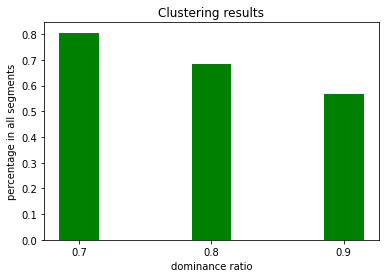

In [70]:
idx=[0, 1, 2]
threshold_list=[0.7, 0.8, 0.9]
values=[0.8055105348460292, 0.6855753646677472, 0.5656401944894651]
plt.bar(idx, values, color='g', width=0.3)
plt.xticks(idx, threshold_list)
plt.xlabel("dominance ratio")
plt.ylabel("percentage in all segments")
plt.title("Clustering results")
plt.show()

In [72]:
d_threshold=0.7

first_=[]

for i, item in enumerate(bucket_A):

    user_cnt=Counter(np.array(item)[:,3])
    ratio_1=(user_cnt['1']+user_cnt['12']+user_cnt['21']+user_cnt['11'])/sum(user_cnt.values())
    ratio_2=(user_cnt['2']+user_cnt['12']+user_cnt['21']+user_cnt['22'])/sum(user_cnt.values())
    if ratio_1>d_threshold or ratio_2>d_threshold:
        first_.append(item)

for i, item in enumerate(first_):
    if i==10:
        break
    # task_cnt=Counter(np.array(item)[:,4])
    # print(task_cnt)
    print(np.array(item))

[['M17' 'ON' '1226295097.99985' '1' '4']
 ['M14' 'OFF' '1226295098.907769' '1' '4']
 ['M16' 'ON' '1226295099.334769' '1' '4']
 ['M16' 'OFF' '1226295100.713119' '1' '4']
 ['M15' 'OFF' '1226295102.586849' '1' '4']
 ['M17' 'OFF' '1226295103.06487' '1' '4']
 ['M15' 'ON' '1226295141.468899' '2' '3']
 ['M16' 'ON' '1226295142.424679' '2' '3']
 ['M17' 'ON' '1226295143.805299' '1' '1']]
[['M17' 'OFF' '1226295144.78128' '1' '1']
 ['M16' 'OFF' '1226295145.08505' '1' '1']
 ['M15' 'OFF' '1226295145.383899' '1' '1']
 ['M17' 'ON' '1226295189.865099' '1' '1']
 ['I6' 'PRESENT' '1226295191.57974' '1' '1']
 ['M17' 'OFF' '1226295192.051889' '1' '1']]
[['M17' 'ON' '1226295195.754509' '1' '1']
 ['M17' 'OFF' '1226295198.044519' '1' '1']
 ['M26' 'ON' '1226295198.363039' '1' '1']
 ['M17' 'ON' '1226295201.012619' '1' '1']
 ['I4' 'PRESENT' '1226295202.2011' '1' '1']
 ['I4' 'ABSENT' '1226295204.046519' '1' '1']
 ['I4' 'PRESENT' '1226295204.66789' '1' '1']
 ['M17' 'OFF' '1226295206.194999' '1' '1']
 ['M26' 'OFF' '

In [87]:
tuA=Counter(np.array(online_group_A)[:,3])
ratio_a1=(tuA['1']+tuA['12']+tuA['21']+tuA['11'])/sum(tuA.values())
ratio_a2=(tuA['2']+tuA['12']+tuA['21']+tuA['22'])/sum(tuA.values())

tuB=Counter(np.array(online_group_B)[:,3])
ratio_b1=(tuB['1']+tuB['12']+tuB['21']+tuB['11'])/sum(tuB.values())
ratio_b2=(tuB['2']+tuB['12']+tuB['21']+tuB['22'])/sum(tuB.values())

avg_1=ratio_a1*sum(tuA.values())+ratio_b1*sum(tuB.values())
avg_1/=(sum(tuA.values())+sum(tuB.values()))

avg_2=ratio_a2*sum(tuA.values())+ratio_b2*sum(tuB.values())
avg_2/=(sum(tuA.values())+sum(tuB.values()))

print(avg_1, avg_2)

0.5294117647058824 0.6264505802320929


In [11]:
trans_time=[]
raw_=event_dict['adlmr']
# print(len(event_dict['adlmr']), len(trans_dict['adlmr']))
for idx in trans_dict['adlmr']:
    trans_time.append(raw_[idx][2])
# print(trans_time[:10])

In [12]:
cnt=0
interval=30
false_idx_A=[]
false_seg_A=[]
for i, segment in enumerate(bucket_A):
    ft, lt=segment[0][2], segment[-1][2]
    if (abs(np.array(trans_time)-ft)<interval).sum()!=0:
        cnt+=1
    elif (abs(np.array(trans_time)-lt)<interval).sum()!=0:
        cnt+=1
    else:
        false_seg_A.append(segment)
        false_idx_A.append(i)

false_idx_B=[]
false_seg_B=[]
for i, segment in enumerate(bucket_B):
    ft, lt=segment[0][2], segment[-1][2]
    if (abs(np.array(trans_time)-ft)<interval).sum()!=0:
        cnt+=1
    elif (abs(np.array(trans_time)-lt)<interval).sum()!=0:
        cnt+=1
    else:
        false_seg_B.append(segment)
        false_idx_B.append(i)

print(cnt)
print(cnt/len(trans_time))
print(len(false_seg_A), len(false_seg_B))
print(len(false_idx_A), len(false_idx_B))

423
0.7356521739130435
89 105
89 105


In [5]:
with open('./save/online_A_dict','rb') as f:
    dictA=pkl.load(f)
with open('./save/online_B_dict','rb') as f:
    dictB=pkl.load(f)

wbtA=dictA['wbt']; wtA=dictA['wt']; watA=dictA['wat']; fbA=dictA['fb']; fA=dictA['f']; faA=dictA['fa']
wbtB=dictB['wbt']; wtB=dictB['wt']; watB=dictB['wat']; fbB=dictB['fb']; fB=dictB['f']; faB=dictB['fa']

In [23]:
false_seg_A[34:39]

[[['M7', 'OFF', 1226393506.438179, '21', '1313'],
  ['M7', 'ON', 1226393506.91012, '21', '1313'],
  ['M6', 'OFF', 1226393508.21199, '21', '1313'],
  ['M6', 'ON', 1226393510.111639, '21', '1313'],
  ['M8', 'OFF', 1226393511.548, '21', '1313'],
  ['M7', 'OFF', 1226393512.20911, '21', '1313'],
  ['M6', 'OFF', 1226393513.99263, '21', '1313'],
  ['M6', 'ON', 1226393517.12856, '21', '1313'],
  ['M6', 'OFF', 1226393521.978319, '21', '1313'],
  ['M6', 'ON', 1226393523.952589, '21', '1313'],
  ['M9', 'ON', 1226393525.72529, '21', '1313']],
 [['M6', 'OFF', 1226393526.24568, '21', '1313'],
  ['M9', 'OFF', 1226393527.602989, '21', '1313'],
  ['M6', 'ON', 1226393537.32766, '21', '1313'],
  ['M6', 'OFF', 1226393539.122529, '21', '1313'],
  ['M6', 'ON', 1226393540.62804, '21', '1313'],
  ['M10', 'ON', 1226393543.335489, '21', '1313']],
 [['M6', 'OFF', 1226393543.872639, '21', '1313'],
  ['M10', 'OFF', 1226393547.712579, '12', '1313'],
  ['M10', 'ON', 1226393563.08344, '12', '1313'],
  ['M6', 'ON', 12

In [24]:
target_seg=false_seg_A[34:39]
target_idx=false_idx_A[34:39]
check=[peaks_A[item] for item in target_idx]
# fb_target=[fbA[item] for item in check]
# f_target=[fA[item] for item in check]
# fa_target=[faA[item] for item in check]
for item in check:
    print(item)
    print(online_group_A[item])
    # print(np.array(fbA[item]))
    # print(np.array(fA[item]))
    # print(np.array(faA[item]))
    # v_b, v_a=np.array([fbB[item], fB[item]]), np.array([fB[item], faB[item]])
    v_b, v_a=np.array([fbA[item], fA[item]]), np.array([fA[item], faA[item]])
    print(Densratio(x=v_b, y=v_a).SEPDiv)
    # print(subscoreB[item])
    print(subscoreA[item])
# false_seg_B[75:80]
# print([subscoreB[item] for item in check])

913
['M7', 'OFF', 1226393506.438179, '21', '1313']
Similarity (Kernel center and numer)
[[1.00000000e+00 7.63972774e-17]
 [7.63972774e-17 1.00000000e+00]]
Similarity (Kernel center and denom)
[[7.63972774e-17 1.00000000e+00]
 [1.67523556e-16 8.05422963e-01]]
0.45190393150767033
0.45190393150767033
924
['M6', 'OFF', 1226393526.24568, '21', '1313']
Similarity (Kernel center and numer)
[[5.78980674e-04 1.00000000e+00]
 [1.00000000e+00 5.78980674e-04]]
Similarity (Kernel center and denom)
[[1.00000000e+00 5.78980674e-04]
 [5.22324289e-01 1.25771950e-03]]
0.4514425601921361
0.4514425601921361
930
['M6', 'OFF', 1226393543.872639, '21', '1313']
Similarity (Kernel center and numer)
[[1.00000000e+00 1.64352933e-14]
 [1.64352933e-14 1.00000000e+00]]
Similarity (Kernel center and denom)
[[1.64352933e-14 1.00000000e+00]
 [1.02963812e-13 2.30244408e-01]]
0.45125042970442036
0.45125042970442036
936
['M6', 'OFF', 1226393568.93249, '21', '1313']
Similarity (Kernel center and numer)
[[1.00000000e+00 1.

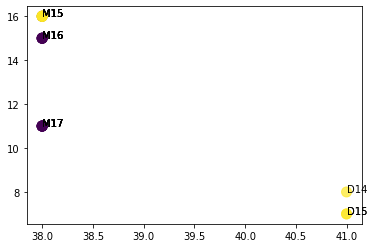

In [280]:
target=false_seg_B[35:37]
for segment in target:
    c=[coordinate[item[0]] for item in segment]
    c_x=[coordinate[item[0]][0] for item in segment]
    c_y=[coordinate[item[0]][1] for item in segment]
    r=[int(item[3]) for item in segment]
    # fig, ax=plt.subplots()

    plt.scatter(c_x, c_y, c=r, alpha=0.7, s=1e2)
    for j in range(len(segment)):
        plt.annotate(segment[j][0], c[j], label=r[j])
    # ax.legend(*sc.legend_elements(num=1), title='resident')
plt.show()

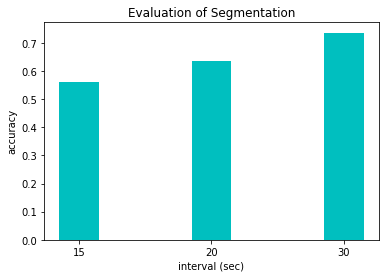

In [132]:
idx=[0, 1, 2]
threshold_list=['15', '20', '30']
values=[0.5617391304347826, 0.6347826086956522, 0.7356521739130435]
plt.bar(idx, values, color='c', width=0.3)
plt.xticks(idx, threshold_list)
plt.xlabel("interval (sec)")
plt.ylabel("accuracy")
plt.title("Evaluation of Segmentation")
plt.show()

In [ ]:
for item in event_dict.keys():
    print("""
        dataset_name: {},
        event_length: {},
        number_of_unique_sensor: {},
        number_of_transition: {}
    """.format(item, len(event_dict[item]), len(set(np.array(event_dict[item])[:,0])), len(trans_dict[item])) )

In [27]:
SEG_result=[]
SEG=[]
events=event_dict['adlmr']
win_size=30
view_size=2
threshold=0.3

event_locations=[]

fcm=FCM(n_clusters=2, max_iter=50)

group_a=[]
group_b=[]
prev_center, prev_group=None, None
center=[]

start=time.time()


print(len(events))
for i, event in enumerate(events):
    event_locations.append(coordinate[event[0]])
    if i%1000==0:
        print("{}/{}, elapsed time: {}".format(i, len(events)-1, time.time()-start))
        with open('./save/online_group_A','wb') as f:
            pkl.dump(group_a, f)
        with open('./save/online_group_B','wb') as f:
            pkl.dump(group_b, f)
        with open('./save/online_centers','wb') as f:
            pkl.dump(center, f)
    # ADDj=False
    # if len(SEG)==0:
    #     segment=[]
    #     segment.append(event)
    #     SEG.append(segment)
    #     ADDj=True
    # else:
    if len(event_locations)<=2:
        continue

    fcm.fit(np.array(event_locations))
    center_a, center_b=fcm.centers
    # print(i, fcm.centers)
    # center_dict={'a': center_a, 'b': center_b}
    # center.append(fcm.centers)
    label=int(fcm.predict(np.array([coordinate[event[0]]]))[0])
    
    if prev_center==None:
        print(fcm.centers)
        prev_center={0: center_a, 1: center_b}
        prev_group={0: group_a, 1: group_b}
        center.append(np.array([center_a, center_b]))
        if label==0:
            group_a.append(event)
        else:
            group_b.append(event)
    else:
        # distance comparison
        current_0=fcm.centers[0]
        dist_0=np.linalg.norm(prev_center[0]-current_0) # distance between prev 0 and current 0
        dist_1=np.linalg.norm(prev_center[1]-current_0) # distance between prev 1 and current 0

        if min(dist_0, dist_1)==dist_0: # prev 0 is current 0
            prev_group[label].append(event)
            prev_center={0: center_a, 1: center_b}
            center.append(np.array([center_a, center_b]))
        else: # prev 1 is current 0
            prev_group[abs(label-1)].append(event)
            prev_center={0: center_b, 1: center_a}
            prev_group={0: group_b, 1: group_a}
            center.append(np.array([center_b, center_a]))
        # for idx, seg in enumerate(SEG):
        #     # if len(seg)!=0:
        #     seg_first, seg_last=seg[0], seg[-1]
        #     last_label=fcm.predict(np.array([coordinate[seg_last[0]]]))[0]

        #     fcm_check=True if event_label==last_label else False

        #     if fcm_check: # do cpd_check
        #         if last_label==0:
        #             w_snd_last=group_A[-win_size-1:-1]
        #             w_last, w_target= group_A[-win_size:], group_A[-win_size+1:]+[event]
        #         else:
        #             w_snd_last=group_B[-win_size-1:-1]
        #             w_last, w_target= group_B[-win_size:], group_B[-win_size+1:]+[event]
                
        #         if len(w_snd_last)<win_size:
        #             w_snd_last=[seg_first for i in range(win_size-len(w_snd_last))]+w_snd_last
        #             w_last=[seg_first for i in range(win_size-len(w_last))]+w_last
        #             w_target=[seg_first for i in range(win_size-len(w_target))]+w_target

        #         f_snd_last=extract_feature(w_snd_last, sensor_set, coordinate)
        #         f_last=extract_feature(w_last, sensor_set, coordinate)
        #         f_target=extract_feature(w_target, sensor_set, coordinate)
                
        #         v_last, v_target= np.array([f_snd_last, f_last]), np.array([f_last, f_target])
        #         dr=Densratio(x=v_last, y=v_target)
        #         # print(dr.KLDiv, dr.PEDiv, dr.SEPDiv)
        #         score=dr.SEPDiv
        #         if last_label==0:
        #             score_A.append(score)
        #         else:
        #             score_B.append(score)
        #         cpd_check=True if score>threshold else False

        #         if not cpd_check: # same cluster and non-transition
        #             seg.append(event)
        #             ADDj=True
        #         else:   # same cluster and transition
        #             SEG_result.append(seg)
        #             SEG[idx]=[event]
        #             ADDj=True
        #         break
        # if ADDj==False:
        #     SEG.append([event])
    # print(i, time.time()-start)
    # print(i)
    # print(len(group_A), len(group_B))

17231
0/17230, elapsed time: 0.00039839744567871094
[[28.00000016 13.21618638]
 [31.91928223  7.08674558]]
1000/17230, elapsed time: 542.0115659236908
2000/17230, elapsed time: 1158.926739692688
3000/17230, elapsed time: 1769.6291737556458
4000/17230, elapsed time: 2391.890565633774
5000/17230, elapsed time: 3029.4643619060516


KeyboardInterrupt: 

In [ ]:
"""
    Pseudo-code

    Input:  Sensor Events S_={S1, S2, ..., Sn}
            ADDj (initial status of sensor event Sj)
                * If Sj is included in any segment, True. Otherwise False.
    Output: Sensor Segments SEG_={SEG1, ..., SEGm}

    (Method)    FCM check: FCM(Si, Sj) -> True/False
                    * if Si and Sj are in the same cluster, True. Otherwise False.
                CPD check: CPD(Sk, Sp) -> True/False
                    * ?

    while Sj and ADDj == False:
        If len(SEG_)==0:
            create SEG1
            SEG1.append(Sj)
            ADDj=True
        else
            for segment in SEG_:
                if len(segment)!=0:
                    segment_last=segment[-1]
                    segment_first=segment[0]
                    fcm1=FCM(Sj, segment_last)
                    cpd1=CPD(Sj, segment_last)
                    if fcm1 and cpd1:
                        segment.append(Sj)
                        ADDj=True
                    elif fcm1 and (not cpd1):
                        process segment
                        clear segment
                        segment.append(Sj)
                        ADDj=True
                    endif
                (endif)
            endfor

            if ADDj==False: # should create new subsequence.
                create SEG(m+1)
                SEG(m+1).append(Sj)
            endif
        endif
    endwhile
"""